In [126]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import matplotlib.patches as patches

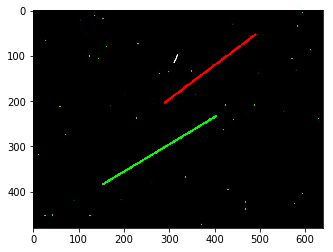

In [127]:
#Frame dimensions

vid = cv2.VideoCapture('video-0.avi')

#while vid.isOpened():
flag, frame = vid.read()

#canny(vid, destinati)

frame.shape

plt.imshow(frame)


    


In [128]:

#keep only one color channel
def process_line(frame, color_channel):
    frame_color = frame.copy()
    frame_color = frame_color[:,:,color_channel]
    
    
    kernel = np.ones((3,3),np.uint8)
    frame_color = cv2.erode(frame_color, kernel, iterations = 1)
    frame = cv2.dilate(frame_color, kernel, iterations = 1)
    
    return frame_color

In [129]:
def hough_lines_no_return(frame):
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = frame
    gray = np.where(gray < 10, 0, gray).astype(np.uint8)
    edges = cv2.Canny(gray, threshold1 = 50, threshold2= 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold = 100, maxLineGap = 10 )


    print(lines.shape)


    for i in range(lines.shape[0]):
        for x1,y1,x2,y2 in lines[i]:
            print(x1, y1, x2,y2)
            plt.plot([x1,x2],[y1,y2], 'g-')
    
    
    plt.imshow(frame)



In [130]:
#function returns only one line 
def hough_lines_return(frame):
    gray = frame
    gray = np.where(gray < 10, 0, gray).astype(np.uint8)
    edges = cv2.Canny(gray, threshold1 = 50, threshold2= 150)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold = 100, maxLineGap = 10 )

    print('Number of found lines: ' + str(lines.shape[0]))
    
    (x1,y1,x2,y2) = lines[0,0,:]
    
    print(x1,y1,x2,y2)
    return (x1,y1,x2,y2)


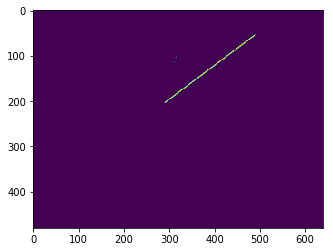

In [131]:
#proba procesiranja linija po boji

frame_new = process_line(frame, 0)

plt.imshow(frame_new)


(2, 1, 4)
292 204 490 55
293 200 489 53


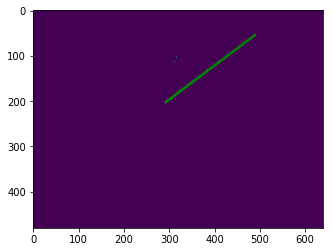

In [132]:
hough_lines_no_return(frame_new)

### Boje se izdvajaju po color kanalu, posto su linije ili plave ili zelene boje

Number of found lines: 2
292 204 490 55
Number of found lines: 3
155 384 403 235


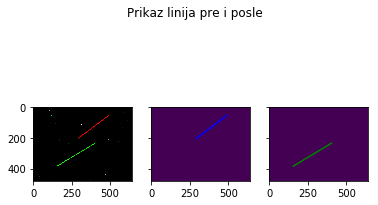

In [133]:
BLUE = 0
GREEN = 1

frame_blue = process_line(frame, BLUE)
blue_line = hough_lines_return(frame_blue)
frame_green = process_line(frame, GREEN)
green_line = hough_lines_return(frame_green)

f, (overall_plot, blue_plot, green_plot) = plt.subplots(1,3, sharey = True)

f.suptitle('Prikaz linija pre i posle')
overall_plot.imshow(frame)

blue_plot.plot([blue_line[0], blue_line[2]], [blue_line[1], blue_line[3]], 'b-')
blue_plot.imshow(frame_blue)

green_plot.plot([green_line[0], green_line[2]], [green_line[1], green_line[3]], 'g-')
green_plot.imshow(frame_green)

### Detekcija brojeva u statickoj slici

In [134]:
def green_mask(frame):
    dummy_frame = frame.copy()
    
    hsv = cv2.cvtColor(dummy_frame, cv2.COLOR_BGR2HSV)
    
    lower_green = (40,40,40)
    upper_green = (70, 255, 255)

#     lower_green = (100,100,60)
#     upper_green = (123, 255, 255)
    
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    res = cv2.bitwise_and(dummy_frame, dummy_frame, mask = mask)
    
    return 255 - mask


In [135]:
def blue_mask(frame):
    dummy_frame = frame.copy()
    
    hsv = cv2.cvtColor(dummy_frame, cv2.COLOR_BGR2HSV)
    
#     lower_red = (10,50,20)
#     upper_red = (179, 255, 255)
    
    lower_blue = (100,100,60)
    upper_blue = (123, 255, 255)
    
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    res = cv2.bitwise_and(dummy_frame, dummy_frame, mask = mask)
    
    return 255 - mask


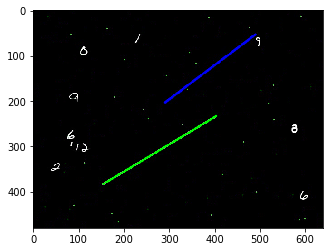

In [142]:
#Take frame with specific number
SELECTED_FRAME = 560
vid.set(1, SELECTED_FRAME)

flag, number_frame = vid.read() 


#Show it up

plt.imshow(number_frame[..., ::-1])

In [144]:
#cleans numbers from possible blue or green color
#and convert to grayscale if wanter
def extract_numbers(frame, gray = False):
    mask_g = green_mask(frame)
    no_green_frame = cv2.bitwise_and(frame, frame, mask = mask_g)
    mask_r = blue_mask(no_green_frame)
    res = cv2.bitwise_and(no_green_frame, no_green_frame, mask = mask_r)
    
    if(gray):
        res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
    
    return res

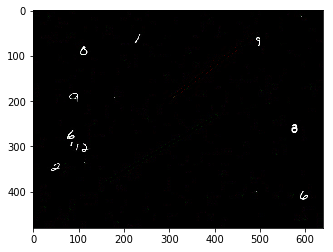

In [145]:

digit_frame = extract_numbers(number_frame)
plt.imshow(digit_frame, cmap = 'gray')

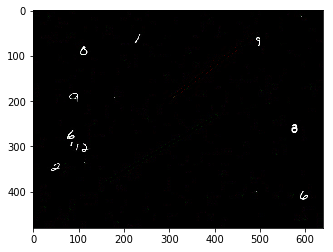

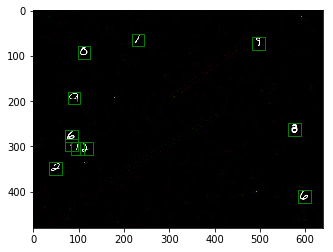

11


In [146]:
#bw_frame = cv2.Canny(digit_frame, threshold1 = 10, threshold2= 150)
gray = cv2.cvtColor(digit_frame, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
binary = cv2.dilate(binary, (5, 5), iterations=3)

(im2, contours, hierarchy) = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(digit_frame)
# kernel = np.ones((5,5),np.uint8)
# digit_frame = cv2.erode(digit_frame, kernel, iterations = 1)
# digit_frame = cv2.dilate(digit_frame, kernel, iterations = 2)
bboxes = []
for c in contours:
#filter out the noise
    if cv2.contourArea(c) < 20:
        continue
            
    #get bounding box 28x28 from countour
    
    (x, y, w, h) = cv2.boundingRect(c)
    x = x - int((28 - w)/2)
    y = y - int((28 - h)/2)
    w = 28
    h = 28
    bboxes.append([x, y, w, h])
        
# #     draw bounding box



figure, ax = plt.subplots(1)

ax.imshow(digit_frame)
for bbox in bboxes:
    (x, y, w, h) = bbox
       
    rect = patches.Rectangle((x,y), w, h, linewidth = 1, edgecolor = 'g', fill = False) 
    ax.add_patch(rect)
    

    
plt.show()
    
print(len(bboxes))

In [140]:
#Makes python list of ndarray images for each digit it found
def number_array_box(frame):
    #for each rectangle box, 
    #append the found number to number array
    found_number_array = []
    for bbox in bboxes:
        (x, y, w, h) = bbox
        found_number = frame[y:y+h, x:x+w,:]
        found_number_array.append(found_number)

    

    #TODO: convert to 28x28 format and make it in numpy array, not list
    #make n subplots and attach to each of them given number
    
    return found_number_array

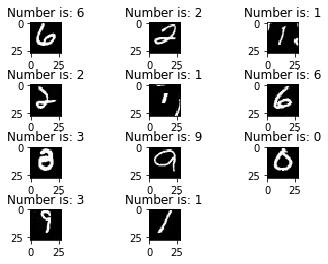

In [147]:
#now with original image
found_number_array = number_array_box(number_frame)
#Make sublots which are gonna represent each rectangle
index = 1
n = len(found_number_array)
plt.subplots_adjust(hspace = 1)
for found_number in found_number_array:
    ax = plt.subplot(np.ceil(n/3), 3, index)
    res = extract_numbers(found_number)
    res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY) 
    res = res / 255
    
   
    ax.set_title('Number is: ' + str(predict(res[np.newaxis,:, :, np.newaxis])))
    ax.imshow(res, cmap = 'gray')
    
    np.savetxt('image_' + str(index), res)
    index = index + 1



### Klasifikovanje brojeva po CNN-u

In [97]:
from keras.models import load_model
from keras.models import model_from_json

mnist_model = load_model('model_1.h5')
def predict(image):
    return np.argmax(mnist_model.predict([image]))

In [155]:
dule = [1, 3,4,5]

dule[-1]

5

In [153]:
from mathutils.geometry import intersect_point_line

ModuleNotFoundError: No module named 'mathutils'

In [156]:
def neki(niz):
    niz.append(2)
    
    
niz = [1]

print(len(niz))
neki(niz)
print(len(niz))

1
2
